# (VAD) Velocity Azimuth Display

Argonne National Laboratory

In [1]:
%%time
import glob
from matplotlib import animation
import matplotlib.pyplot as plt
import netCDF4
import numpy.ma as ma
import numpy as np
import pyart
import warnings
# warnings.filterwarnings("ignore")
%matplotlib inline
from IPython.display import Image, display


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119

CPU times: user 712 ms, sys: 248 ms, total: 960 ms
Wall time: 717 ms


In [2]:
"""
pyart.retrieve.velocity_azimuth_display
=======================================

Retrieval of VADs from a radar object.

.. autosummary::
    :toctreeL generated/
    :template: dev_template.rst

    velocity_azimuth_display
    _interval_mean
    _sd_to_uv
    _vad_calculation

"""

import numpy as np

from pyart.config import get_field_name
from pyart.core import HorizontalWindProfile



def velocity_azimuth_display(radar, vel_field=None, z_want=None,
                             gatefilter=None):
    """
    Velocity azimuth display.
    
    Creates a VAD object containing U Wind V Wind and height, that
    can then be used to plot and produces the velocity azimuth
    display.

    Parameters
    ----------
    radar : Radar
        Radar object used.
    velocity : string
        Velocity field to use for VAD calculation.

    Other Parameters
    ----------------
    z_want : array
        Heights for where to sample vads from.
        None will result in np.linespace(0, 10000, 100).
    gatefilter : GateFilter
        A GateFilter indicating radar gates that should be excluded
        from the vad calculation.

    Returns
    -------
    height : array
        Heights in meters above sea level at which horizontal winds were
        sampled.
    speed : array
        Horizontal wind speed in meters per second at each height.
    direction : array
        Horizontal wind direction in degrees at each height.
    u_wind : array
        U-wind mean in meters per second.
    v_wind : array
        V-wind mean in meters per second.

    Reference
    ---------
    Michelson, D. B., Andersson, T., Koistinen, J., Collier, C. G., Riedl, J.,
    Szturc, J., Gjertsen, U., Nielsen, A. and Overgaard, S. (2000) BALTEX Radar
    Data Centre Products and their Methodologies. In SMHI Reports. Meteorology
    and Climatology. Swedish Meteorological and Hydrological Institute, Norrkoping.

    """
    speeds = []
    angles = []
    heights = []
    z_gate_data = radar.gate_z['data']
    if z_want is None:
        z_want = np.linspace(0, 1000, 100)

    if vel_field is None:
        vel_field = get_field_name('velocity')

    if gatefilter is not None:
        velocities = np.ma.masked_where(
            gatefilter.gate_excluded,
            radar.fields[vel_field]['data'])
    else:
        velocities = radar.fields[vel_field]['data']

    for i in range(len(radar.sweep_start_ray_index['data'])):
        index_start = radar.sweep_start_ray_index['data'][i]
        index_end = radar.sweep_end_ray_index['data'][i]
        if not (index_end - index_start) % 2 == 0:
            index_end = index_end - 1

        used_velocities = velocities[index_start:index_end]
        azimuth = radar.azimuth['data'][index_start:index_end]
        elevation = radar.fixed_angle['data'][i]
        speed, angle = _vad_calculation(
            used_velocities, azimuth, elevation)

        print('max height', z_gate_data[index_start, :].max(),
              'meters')
        speeds.append(speed)
        angles.append(angle)
        heights.append(z_gate_data[index_start, :])

    speed_array = np.concatenate(speeds)
    angle_array = np.concatenate(angles)
    height_array = np.concatenate(heights)
    arg_order = height_array.argsort()
    speed_ordered = speed_array[arg_order]
    height_ordered = height_array[arg_order]
    angle_ordered = angle_array[arg_order]
    u_ordered, v_ordered = _sd_to_uv(speed_ordered, angle_ordered)
    u_mean = _interval_mean(u_ordered, height_ordered, z_want)
    v_mean = _interval_mean(v_ordered, height_ordered, z_want)
    vad = HorizontalWindProfile.from_u_and_v(
        z_want, u_mean, v_mean)
    return vad


def _vad_calculation(velocity_field, azimuth, elevation):
    """ Calculates VAD for a scan, returns speed and angle
    outdic = vad_algorithm(velocity_field, azimuth, elevation)
    velocity_field is a 2D array, azimuth is a 1D array,
    elevation is a number. All in degrees, m outdic contains
    speed and angle. """
    nrays, nbins = velocity_field.shape
    nrays2 = nrays // 2
    velocity_count = np.empty((nrays2, nbins, 2))
    velocity_count[:, :, 0] = velocity_field[0:nrays2, :]
    velocity_count[:, :, 1] = velocity_field[nrays2:, :]
    sinaz = np.sin(np.deg2rad(azimuth))
    cosaz = np.cos(np.deg2rad(azimuth))
    sumv = np.ma.sum(velocity_count, 2)
    vals = np.isnan(sumv)
    vals2 = np.vstack((vals, vals))

    # Line below needs to be changed to 'is not' expression.
    count = np.sum(np.isnan(sumv) == False, 0)

    aa = count < 8
    vals[:, aa] = 0
    vals2[:, aa] = 0
    count = np.float64(count)
    count[aa] = np.nan
    u_m = np.array([np.nansum(sumv, 0) // (2 * count)])
    count[aa] = 0

    cminusu_mcos = np.zeros((nrays, nbins))
    cminusu_msin = np.zeros((nrays, nbins))
    sincos = np.zeros((nrays, nbins))
    sin2 = np.zeros((nrays, nbins))
    cos2 = np.zeros((nrays, nbins))

    for i in range(nbins):
        cminusu_mcos[:, i] = cosaz * (velocity_field[:, i] - u_m[:, i])
        cminusu_msin[:, i] = sinaz * (velocity_field[:, i] - u_m[:, i])
        sincos[:, i] = sinaz * cosaz
        sin2[:, i] = sinaz**2
        cos2[:, i] = cosaz**2

    cminusu_mcos[vals2] = np.nan
    cminusu_msin[vals2] = np.nan
    sincos[vals2] = np.nan
    sin2[vals2] = np.nan
    cos2[vals2] = np.nan
    sumcminu_mcos = np.nansum(cminusu_mcos, 0)
    sumcminu_msin = np.nansum(cminusu_msin, 0)
    sumsincos = np.nansum(sincos, 0)
    sumsin2 = np.nansum(sin2, 0)
    sumcos2 = np.nansum(cos2, 0)
    b_value = (sumcminu_mcos - (sumsincos*sumcminu_msin / sumsin2)) / (
        sumcos2 - (sumsincos**2) / sumsin2)
    a_value = (sumcminu_msin - b_value*sumsincos) / sumsin2
    speed = np.sqrt(a_value**2 + b_value**2) / np.cos(
        np.deg2rad(elevation))
    angle = np.arctan2(a_value, b_value)
    return speed, angle


def _interval_mean(data, current_z, wanted_z):
    """ Find the mean of data indexed by current_z
        at wanted_z on intervals wanted_z+/- delta
        wanted_z. """
    delta = wanted_z[1] - wanted_z[0]
    pos_lower = [np.argsort((current_z - (
        wanted_z[i] - delta / 2.0))**2)[0]
                 for i in range(len(wanted_z))]
    pos_upper = [np.argsort((current_z - (
        wanted_z[i] + delta / 2.0))**2)[0]
                 for i in range(len(wanted_z))]
    mean_values = np.array([data[pos_lower[i]:pos_upper[i]].mean()
                            for i in range(len(pos_upper))])
    return mean_values


def _sd_to_uv(speed, direction):
    """ Takes speed and direction to create u_mean and v_mean. """
    return (np.sin(direction) * speed), (np.cos(direction) * speed)

In [3]:
radar = pyart.io.read('/home/zsherman/dev/training_exercises/data/KLOT20130417_235520_V06.gz')
#radar_sweep = radar.extract_sweeps([5])
#radar = pyart.io.read('/home/zsherman/dev/xsapr_sgp/data/05_19_2017/XSW170519071005.RAW54Z8')

In [4]:
gatefilter = pyart.correct.GateFilter(radar)
gatefilter.exclude_below('reflectivity', 5)
gatefilter.exclude_invalid('velocity')

In [5]:
vad = velocity_azimuth_display(
        radar, 'velocity', z_want=np.linspace(50, 10766, 101), 
        gatefilter=gatefilter)

max height 16378.3196353 meters
max height 16664.336786 meters
max height 18644.1409849 meters
max height 19831.749484 meters
max height 22733.8708519 meters
max height 23349.2962065 meters
max height 28314.2167915 meters
max height 31848.3092148 meters
max height 36936.2556392 meters
max height 44031.5646064 meters
max height 52728.7671706 meters
max height 62490.3668599 meters
max height 76743.0034827 meters
max height 91638.9944802 meters
max height 112526.51153 meters
max height 134714.181605 meters
max height 163740.607128 meters


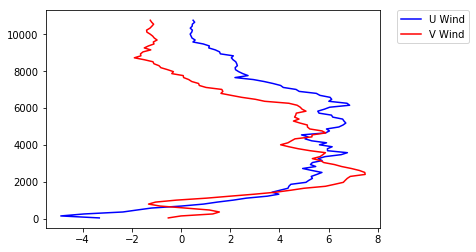

In [6]:
fig = plt.figure()
plt.plot(vad.u_wind, vad.height, 'b-', label='U Wind')
plt.plot(vad.v_wind, vad.height, 'r-', label='V Wind')
#plt.xlim(-40, 40)
#plt.ylim(0, 15000)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [7]:
""" Unit Tests for Py-ART's retrieve/vad.py module. """
from numpy.testing import assert_almost_equal

In [8]:
def test_velocity_azimuth_display():
    test_radar = pyart.testing.make_target_radar()
    height = np.arange(0, 1000, 200)
    speed = np.ones_like(height) * 5
    direction = np.array([0, 90, 180, 270, 45])
    profile = pyart.core.HorizontalWindProfile(height, speed, direction)
    sim_vel = pyart.util.simulated_vel_from_profile(test_radar, profile)
    test_radar.add_field('velocity', sim_vel,
                         replace_existing=True)

    velocity = 'velocity'
    z_want = np.linspace(0, 10, 5)

    vad_height = ([0., 2.5, 5., 7.5, 10.])
    vad_speed = ([4.98634593, 4.93978918, 4.88051406, 
                  4.81868498, 4.75765562])
    vad_direction = ([90.02444907, 90.56749781, 91.28185396, 
                      92.0561715, 92.85184062])
    u_wind = ([-4.98634547, -4.93954688, -4.87929269,
               -4.81558238, -4.75176341])
    v_wind = ([0.00212776, 0.04892636, 0.10918054,
               0.17289085, 0.23670982])

    vad = velocity_azimuth_display(
        test_radar, velocity, z_want)

    assert_almost_equal(vad.height, vad_height, 3)
    assert_almost_equal(vad.speed, vad_speed, 3)
    assert_almost_equal(vad.direction, vad_direction, 3)
    assert_almost_equal(vad.u_wind, u_wind, 3)
    assert_almost_equal(vad.v_wind, v_wind, 3)

In [9]:
test_velocity_azimuth_display()

max height 13.1484458577 meters
